### Final Project Submission

Student name: Luis Diego Vallejos

Student pace: self paced

Scheduled project review date/time: 03/15/2021

Instructor name: Jeff Herman

Blog post URL: https://diegovallejossalas.github.io/time_series_analysis

### The project

This project for Flatiron School Data Science career module 4 contains a forecast and advice for a real state company in order to decide where to invest money. I have to identify the 5 best zipcodes for investment and this includes cuantitative and cualitative elements that I will try to mix in order to choose the best options.
The chosen city for this project is Orlando, FL.

I followed the next steps:

1.- Download necessary libraries, open the dataset and make it user friendly.Check for missing and null values. Add more information as needed.

2.- Transform the data so we can deal with dates. Melt data for ARIMA.

3.- Explore data and define ARIMA function.

4.- Obtain the optimal p,d,q parameters for the top ten zipcodes.

5.- Define the 5 best zipcodes for investment.


#### Case parameters:

The company that needs our services is a small company with just a few years in the market.

## Loading the Data/Filtering for Chosen Zipcodes

Downloading the necessary libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [13]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


As we can see, the dataset is in a wide format. Let's explore deeper before we transform it into a long format. As a first step, we need to rename the RegionName column, Zipcode seems to be the right name.

In [14]:
df.rename({'RegionName': 'Zipcode'}, axis='columns', inplace=True)
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


It was not clear to me the difference between City and Metro columns. Exploring the number of items per column we can assume that the metro column responds to a bigger area.

In [15]:
df.Metro.value_counts()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
                                 ... 
Coffeyville                         1
Cullman                             1
Sedalia                             1
Fredericksburg                      1
Poplar Bluff                        1
Name: Metro, Length: 701, dtype: int64

In [16]:
df.City.value_counts()

New York        114
Los Angeles      95
Houston          88
San Antonio      48
Washington       45
               ... 
Sandy Spring      1
Madras            1
Bryceville        1
Mounds            1
Holliday          1
Name: City, Length: 7554, dtype: int64

The next step is to select the city, in this case Orlando, FL.

In [17]:
orlando = df.loc[df['City'] == 'Orlando']
print(orlando.shape)
orlando.head()

(19, 272)


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
212,72247,32822,Orlando,FL,Orlando,Orange,213,75300.0,75400.0,75500.0,...,173900,175900,177300,178300,179900,182200,184500,186600,189200,191400
320,72252,32828,Orlando,FL,Orlando,Orange,321,131800.0,132400.0,132800.0,...,274500,276100,276700,277400,278800,280600,282300,284100,286500,289200
520,72249,32825,Orlando,FL,Orlando,Orange,521,96200.0,96200.0,96200.0,...,216900,218500,219400,220500,222600,225300,227900,230500,233200,235500
585,72262,32839,Orlando,FL,Orlando,Orange,586,73800.0,73700.0,73600.0,...,148200,150900,153400,156100,160300,164800,167700,169800,171900,173800
922,72261,32837,Orlando,FL,Orlando,Orange,923,117800.0,117600.0,117600.0,...,245000,246400,247400,248300,249900,252200,254400,256600,258900,260800


In [18]:
orlando.isna().sum()

RegionID    0
Zipcode     0
City        0
State       0
Metro       0
           ..
2017-12     0
2018-01     0
2018-02     0
2018-03     0
2018-04     0
Length: 272, dtype: int64

In [19]:
orlando.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 212 to 7894
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 40.5+ KB


Let's calculate the Return On Investment or simply ROI. This step will be helpfull because we can filter the zipcodes with the highest ROI. The easiest way is using the first and last date in the format it currently is.

In [20]:
# I'm using the current format to make the operation easier.
orlando['ROI'] = ((orlando['2018-04'] - orlando['1996-04']) / orlando['1996-04'])
orlando.head()

C:\Users\xdieg\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
212,72247,32822,Orlando,FL,Orlando,Orange,213,75300.0,75400.0,75500.0,...,175900,177300,178300,179900,182200,184500,186600,189200,191400,1.541833
320,72252,32828,Orlando,FL,Orlando,Orange,321,131800.0,132400.0,132800.0,...,276100,276700,277400,278800,280600,282300,284100,286500,289200,1.194234
520,72249,32825,Orlando,FL,Orlando,Orange,521,96200.0,96200.0,96200.0,...,218500,219400,220500,222600,225300,227900,230500,233200,235500,1.448025
585,72262,32839,Orlando,FL,Orlando,Orange,586,73800.0,73700.0,73600.0,...,150900,153400,156100,160300,164800,167700,169800,171900,173800,1.355014
922,72261,32837,Orlando,FL,Orlando,Orange,923,117800.0,117600.0,117600.0,...,246400,247400,248300,249900,252200,254400,256600,258900,260800,1.213922


In [21]:
orlando = orlando.sort_values('ROI',axis=0,ascending=False)
print(orlando.info())
orlando

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 4131 to 1177
Columns: 273 entries, RegionID to ROI
dtypes: float64(220), int64(49), object(4)
memory usage: 40.7+ KB
None


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
4131,72229,32803,Orlando,FL,Orlando,Orange,4132,88100.0,88400.0,88700.0,...,289100,289400,289300,290600,293500,296100,298600,302300,305600,2.468785
5285,72230,32804,Orlando,FL,Orlando,Orange,5286,99100.0,99300.0,99500.0,...,303000,303700,304200,305700,308400,311100,314600,319000,322900,2.258325
4553,72227,32801,Orlando,FL,Orlando,Orange,4554,121000.0,121700.0,122300.0,...,355000,358500,361000,362100,363400,364400,368000,374300,379000,2.132231
3502,72232,32806,Orlando,FL,Orlando,Orange,3503,95300.0,95400.0,95500.0,...,267200,267700,268400,270200,271800,272900,275500,279900,283500,1.974816
7894,72239,32814,Orlando,FL,Orlando,Orange,7895,170200.0,171300.0,172300.0,...,467100,466900,466900,467900,471700,475400,482600,494500,504700,1.965335
6971,72251,32827,Orlando,FL,Orlando,Orange,6972,129300.0,129700.0,130100.0,...,364000,362200,361400,361400,362700,364600,367400,370500,373300,1.887084
2988,72233,32807,Orlando,FL,Orlando,Orange,2989,68300.0,68400.0,68500.0,...,171000,172600,174000,176000,178200,179900,181500,183800,186000,1.723280
212,72247,32822,Orlando,FL,Orlando,Orange,213,75300.0,75400.0,75500.0,...,175900,177300,178300,179900,182200,184500,186600,189200,191400,1.541833
2236,72238,32812,Orlando,FL,Orlando,Orange,2237,107900.0,107900.0,108000.0,...,255200,255300,255600,256200,257600,259000,260500,262700,265000,1.455978
3197,72242,32817,Orlando,FL,Orlando,Orange,3198,95900.0,95800.0,95700.0,...,221000,221500,221800,223200,225600,227700,230000,232800,235100,1.451512


## Data Preprocessing

For the next steps we need to change the format of the data.

In [22]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:-1], format='%Y-%m')

In [23]:
get_datetimes(orlando)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

The next function was provided by Flatiron School

In [24]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

This next function is basically the same than above but returns a dataframe with more data.

In [25]:
def melted_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=False)
    melted = melted.dropna(subset=['value'])
    return melted

In [26]:
orlando_melted = melt_data(orlando)
print(orlando_melted.info())
orlando_melted.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
value    265 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB
None


,value
time,
1996-04-01,106700.000000
1996-05-01,106921.052632
1996-06-01,107105.263158
1996-07-01,107215.789474
1996-08-01,107347.368421


# Step 3: Exploratory Data Analysis and Visualization

In [27]:
sns.set(palette="Set2")

In [28]:
orlandom = melted_data(orlando)
orlandom.set_index('time', inplace = True)
orlandom.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI,value
time,,,,,,,,,
1996-04-01,72229,32803,Orlando,FL,Orlando,Orange,4132,2.468785,88100.0
1996-04-01,72230,32804,Orlando,FL,Orlando,Orange,5286,2.258325,99100.0
1996-04-01,72227,32801,Orlando,FL,Orlando,Orange,4554,2.132231,121000.0
1996-04-01,72232,32806,Orlando,FL,Orlando,Orange,3503,1.974816,95300.0
1996-04-01,72239,32814,Orlando,FL,Orlando,Orange,7895,1.965335,170200.0
1996-04-01,72251,32827,Orlando,FL,Orlando,Orange,6972,1.887084,129300.0
1996-04-01,72233,32807,Orlando,FL,Orlando,Orange,2989,1.723280,68300.0
1996-04-01,72247,32822,Orlando,FL,Orlando,Orange,213,1.541833,75300.0
1996-04-01,72238,32812,Orlando,FL,Orlando,Orange,2237,1.455978,107900.0


Text(0.5, 1.0, 'Mean Value from 1996 to 2018 in Orlando')

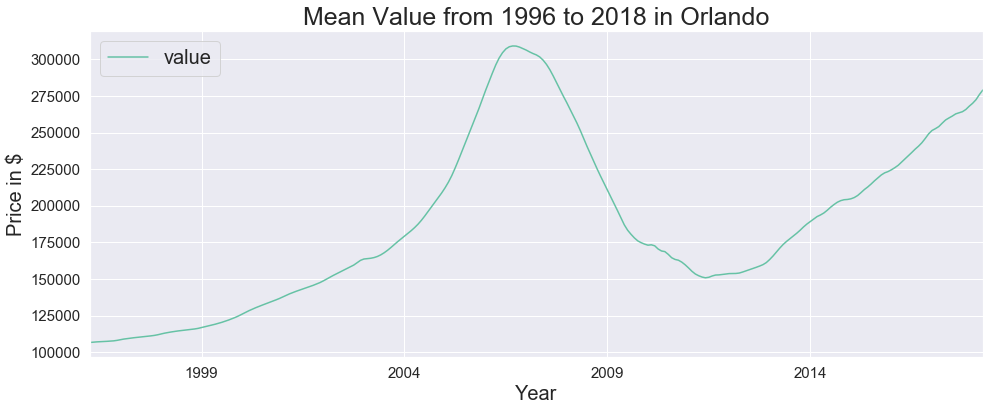

In [175]:
orlando_melted.plot(figsize = (16,6));
plt.ylabel('Price in $', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc = 'upper left',fontsize=20)
plt.title('Mean Value from 1996 to 2018 in Orlando',fontsize=25)

Text(0.5, 1.0, 'Boxplots per Zipcode')

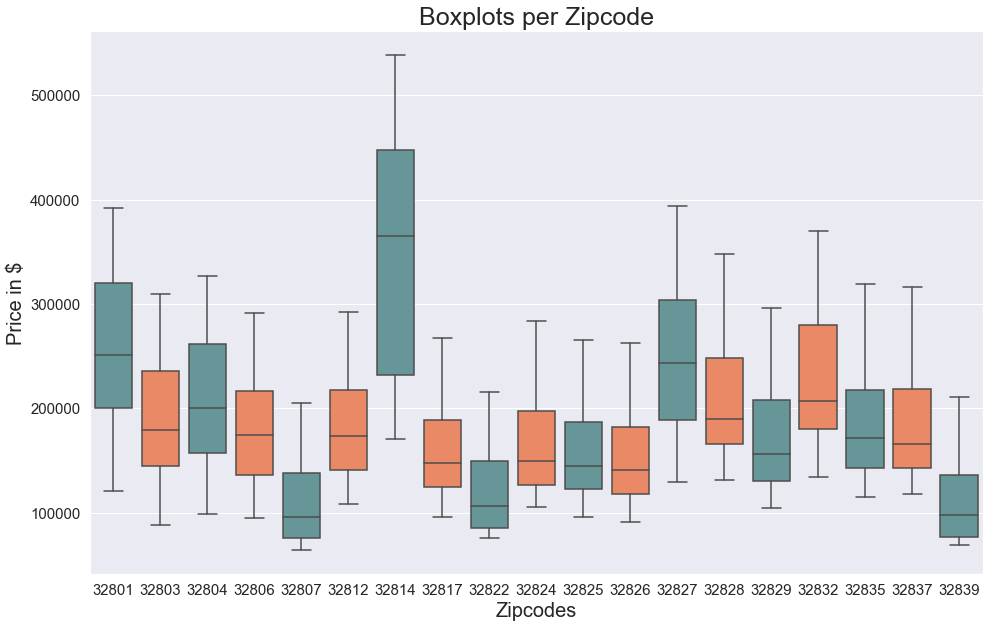

In [176]:
plt.figure(figsize=(16, 10))
sns.boxplot(x="Zipcode", y="value", palette=["cadetblue", "coral"],
            data=orlandom)
plt.ylabel('Price in $', fontsize=20)
plt.xlabel('Zipcodes', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Boxplots per Zipcode',fontsize=25)

With the help of a violin plot we can figure out easier how those values are distributed in the same scale. Both plots are complementary.

Text(0.5, 1.0, 'Violins per Zipcode')

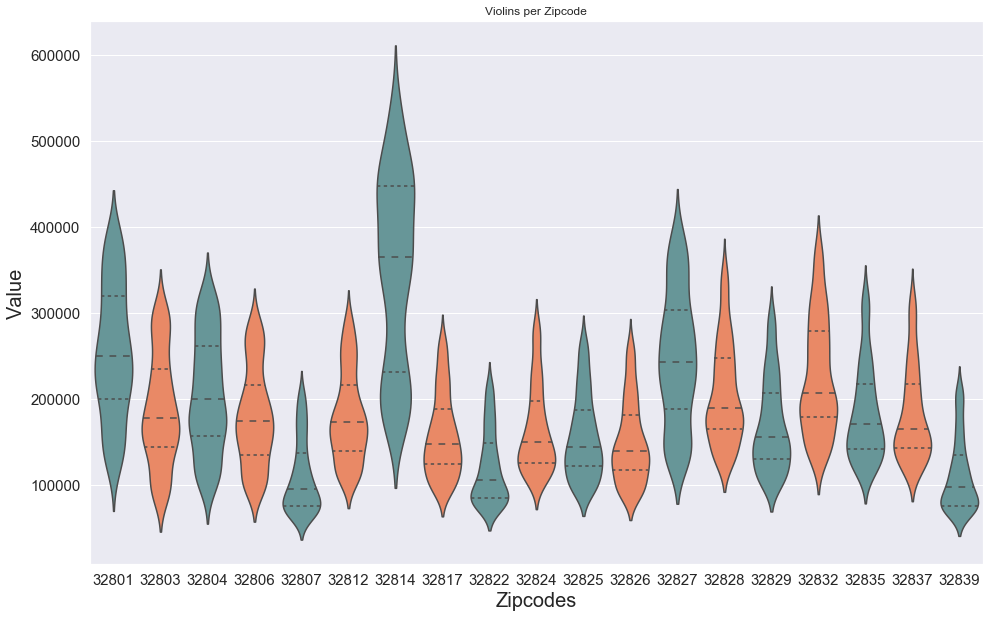

In [31]:
fig = plt.figure()
fig.set_size_inches(16, 10)
sns.violinplot(x='Zipcode', y='value', data=orlandom, scale="width", inner="quartile",palette=["cadetblue", "coral"])
plt.ylabel('Value', fontsize=20)
plt.xlabel('Zipcodes', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Violins per Zipcode')

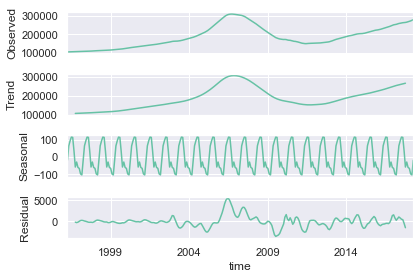

In [33]:
decomp_test = seasonal_decompose(orlando_melted.value)
decomp_test.plot()
plt.show()

The next function tells us if our data is stationary or not. The value we have to focus on is P-Value. If our P-Value is <5 we can say that our data is stationary. If it's >5 is not.

In [50]:
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [666]:
ad_test(orlando_melted['value'])

1. ADF :  -1.7480100291874598
2. P-Value :  0.4065612917547622
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 252
5. Critical Values :
	 1% :  -3.4565688966099373
	 5% :  -2.8730786194395455
	 10% :  -2.5729189953388762


The next function was provided in order to chose the right parameters for ARIMA.

ARIMA comes from Auto-regression(AR) term, the number of lag periods; Integral(I) term for non-stationary differencing and Moving Average(MA) for error term.

In [164]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    print(best_cfg)
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

The master_function returns a melted dataframe and charts to explore seasonality, rolling mean and standard deviation and ARIMA tuning.

In [165]:
def master_function(zip_code):
    df1 = orlando[orlando['Zipcode'] == zip_code]
    df1 = melt_data(df1)
    print(f'First Rows From {zip_code}')
    display(df1.head())
    
    print('')
    print('')
    print('Seasonality')
    df1decomp_test = seasonal_decompose(df1.value)
    df1decomp_test.plot()
    plt.show()
    
    print('')
    print('')
    print('Rolling Meand and Standard Deviation')
    df1_roll_mean = df1.rolling(window=10, center=False).mean()
    df1_roll_std = df1.rolling(window=10, center=False).std()

    fig = plt.figure(figsize=(12,6))
    plt.plot(df1, color='blue',label='Original')
    plt.plot(df1_roll_mean, color='orange', label='Rolling Mean')
    plt.plot(df1_roll_std, color='grey', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('')
    print('')
    print('Rolling Meand and Standard Deviation') 
    plt.figure(figsize=(12,5))
    pd.plotting.autocorrelation_plot(df1);
    plt.show()
    
    
    print('')
    print('')
    print('ARIMA')
          
    df1a = evaluate_models(df1.values, p_values, d_values, q_values)

The final_function returns a plot with the forecast for the next two years. It tells you also the best and worst case scenario for investment expressed in percentage.

In [186]:
def final_function(zip_code,p,d,q):
    df1 = orlando[orlando['Zipcode'] == zip_code]
    df1 = melt_data(df1)    
    
    
    df1model = ARIMA(df1, order=(p,d,q))
    df1model_fit = df1model.fit(disp=0)

    df1forecast = df1model_fit.forecast(24)

    df1actual_foreacst = df1forecast[0]
    df1forecast_conf_int = df1forecast[2]
    
    df1_forecast = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')})
    df1_forecast['forecast'] = df1actual_foreacst
    df1_forecast['lower_bound'] = df1forecast_conf_int[:, 0]
    df1_forecast['upper_bound'] = df1forecast_conf_int[:, 1]
    df1_forecast.set_index('time', inplace = True)
    df_new = pd.concat([df1, df1_forecast])
    
    fig = plt.figure(figsize = (12, 8))
    plt.plot(df_new['value'], label = 'raw data')
    plt.plot(df_new['forecast'], label = 'forecast')
    plt.fill_between(df_new.index, df_new['lower_bound'], df_new['upper_bound'], color="k", alpha=.15,
                    label = 'confidence interval')
    plt.ylabel('Price in $', fontsize=20)
    plt.xlabel('Year', fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend(loc = 'upper left',fontsize=15)
    plt.title(f'Forecast for Orlando {zip_code}',fontsize=25)
    plt.show()
    
    
    print('')
    print('')    
    forcast_2_years = df_new.loc['2020-04-01', 'forecast']
    forcast_lower = df_new.loc['2020-04-01', 'lower_bound']
    forcast_upper = df_new.loc['2020-04-01', 'upper_bound']
    last_price = df1.loc['2018-04-01', 'value']
    predicted_percent_change = (forcast_2_years - last_price) / last_price
    print(f'I would expect a  {np.round(predicted_percent_change * 100, 4)}% return on my investment in {zip_code}')
    best_percent_change = (forcast_upper - last_price) / last_price
    print(f'Best case scenario I would expect a  {np.round(best_percent_change * 100, 4)}% return on my investment in {zip_code}')
    worst_percent_change = (forcast_lower - last_price) / last_price
    print(f'Worst case scenario I would expect a  {np.round(worst_percent_change * 100, 4)}% return on my investment in {zip_code}')

At this point we want to take a deeper look into each zipcode from the top list.

### First Zipcode 32803

ZIP code 32803 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a slightly higher than average population density.

The people living in ZIP code 32803 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of seniors is slightly less than average. There are also an extremely large number of single adults and an extremely small number of families. The percentage of children under 18 living in the 32803 ZIP code is extremely small compared to other areas of the country.

Population	19,020	

Population Density	2,741 people per sq mi

Housing Units	10,684	

Median Home Value	$209,100

Land Area	6.94	sq mi

Water Area	0.94	sq mi

Occupied Housing Units	9,657	

Median Household Income	$53,101	

#### Real Estate and Housing

ZIP code 32803 has a slightly less than average percentage of vacancies.

The majority of household are owned or have a mortgage. Homes in ZIP code 32803 were primarily built in the 1950s. Looking at 32803 real estate data, the median home value of 209,100 is slightly higher than average compared to the rest of the country. It is also slightly less than average compared to nearby ZIP codes. 32803 could be an area to look for cheap housing compared to surrounding areas. Rentals in 32803 are most commonly 2 bedrooms. The rent for 2 bedrooms is normally 1,000+/month including utilities. Prices for rental property include ZIP code 32803 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

Compared to other ZIPs, 32803 has a very small percentage of people that did not graduate high school. The area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32803


,value
time,
1996-04-01,88100.0
1996-05-01,88400.0
1996-06-01,88700.0
1996-07-01,88900.0
1996-08-01,89200.0




Seasonality


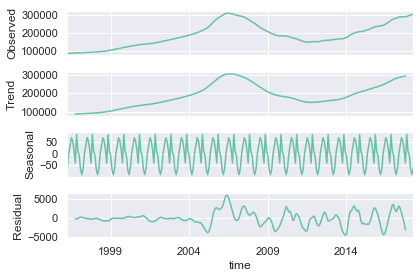



Rolling Meand and Standard Deviation


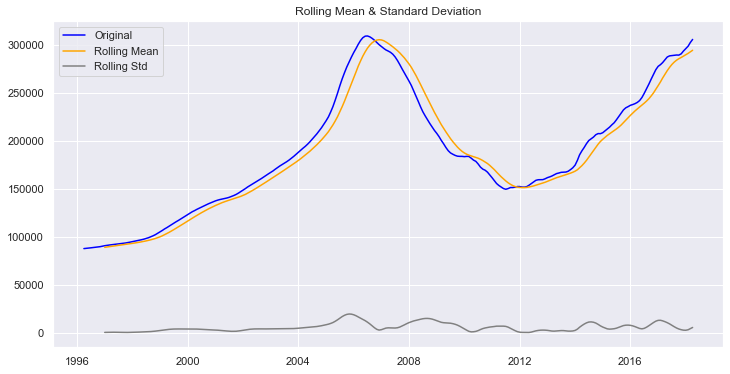



Rolling Meand and Standard Deviation


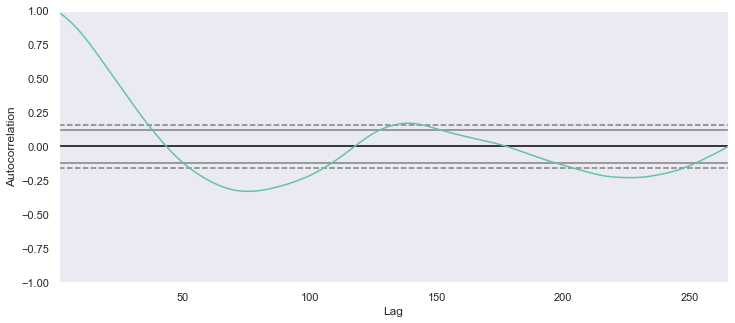



ARIMA
ARIMA(0, 0, 0) MSE=3138404756.187
ARIMA(0, 0, 1) MSE=804272347.480
ARIMA(0, 1, 0) MSE=4334153.504
ARIMA(0, 1, 1) MSE=1327417.697
ARIMA(0, 2, 0) MSE=604940.915
ARIMA(0, 2, 1) MSE=442087.987
ARIMA(0, 2, 2) MSE=453333.066
ARIMA(1, 0, 0) MSE=5866960.023
ARIMA(1, 1, 0) MSE=594715.770
ARIMA(1, 1, 1) MSE=428060.585
ARIMA(1, 1, 2) MSE=439810.374
ARIMA(1, 2, 0) MSE=557541.318
ARIMA(1, 2, 1) MSE=448843.208
ARIMA(1, 2, 2) MSE=446970.796
ARIMA(2, 0, 1) MSE=434245.406
ARIMA(2, 0, 2) MSE=444339.699
ARIMA(2, 1, 1) MSE=435129.991
ARIMA(2, 1, 2) MSE=423011.031
ARIMA(2, 2, 0) MSE=498473.042
ARIMA(2, 2, 1) MSE=435679.124
ARIMA(2, 2, 2) MSE=370113.559
ARIMA(4, 0, 1) MSE=428969.561
ARIMA(4, 0, 2) MSE=365107.447
ARIMA(4, 1, 1) MSE=396116.538
ARIMA(4, 2, 0) MSE=417165.881
ARIMA(4, 2, 1) MSE=404280.355
ARIMA(6, 0, 1) MSE=396972.765
ARIMA(6, 1, 1) MSE=395688.553
ARIMA(6, 2, 0) MSE=422080.734
ARIMA(8, 0, 1) MSE=417030.984
ARIMA(8, 2, 0) MSE=432136.937
Best ARIMA(4, 0, 2) MSE=365107.447
(4, 0, 2)


In [167]:
master_function(32803)

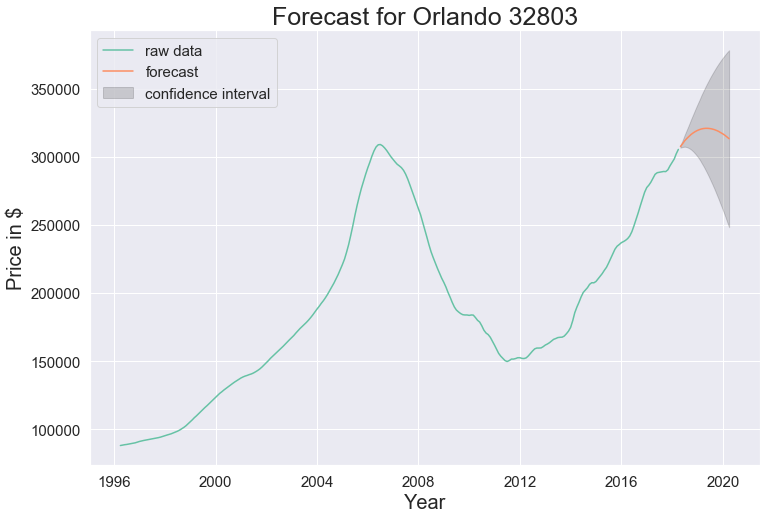



I would expect a  2.5737% return on my investment in 32803
Best case scenario I would expect a  23.8488% return on my investment in 32803
Worst case scenario I would expect a  -18.7014% return on my investment in 32803


In [187]:
final_function(32803,4,0,2)

### Second Zipcode 32804

ZIP code 32804 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a slightly higher than average population density.

The people living in ZIP code 32804 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of middle aged adults is large. There are also an extremely large number of single adults and a small number of families. The percentage of children under 18 living in the 32804 ZIP code is small compared to other areas of the country.

Population	17,312	

Population Density	2,356 people per sq mi

Housing Units	9,145

Median Home Value	$240,700

Land Area	7.35	sq mi

Water Area	1.18	sq mi

Occupied Housing Units	8,152

Median Household Income	$58,548	

#### Real Estate and Housing

ZIP code 32804 has a slightly less than average percentage of vacancies. The Census also indicates that there are one or more nursing homes and universities nearby.

The majority of household are owned or have a mortgage. Homes in ZIP code 32804 were primarily built in the 1950s. Looking at 32804 real estate data, the median home value of 240,700 is high compared to the rest of the country. It is also high compared to nearby ZIP codes. So you are less likely to find inexpensive homes in 32804. Rentals in 32804 are most commonly 2 bedrooms. The rent for 2 bedrooms is normally $1,000+/month including utilities. Prices for rental property include ZIP code 32804 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32804


,value
time,
1996-04-01,99100.0
1996-05-01,99300.0
1996-06-01,99500.0
1996-07-01,99800.0
1996-08-01,100200.0




Seasonality


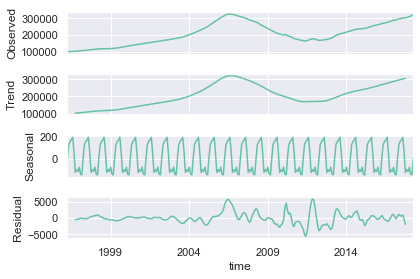



Rolling Meand and Standard Deviation


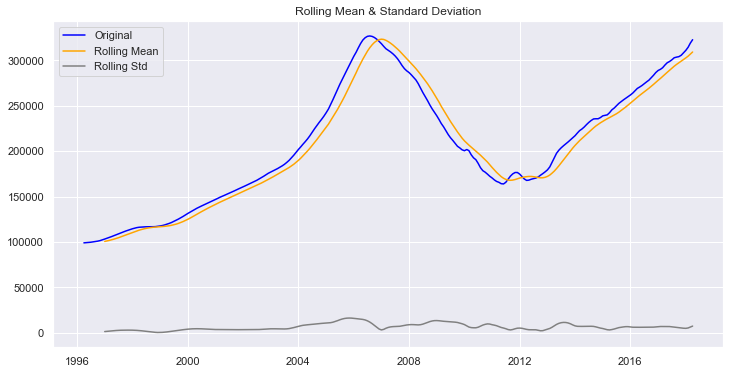



Rolling Meand and Standard Deviation


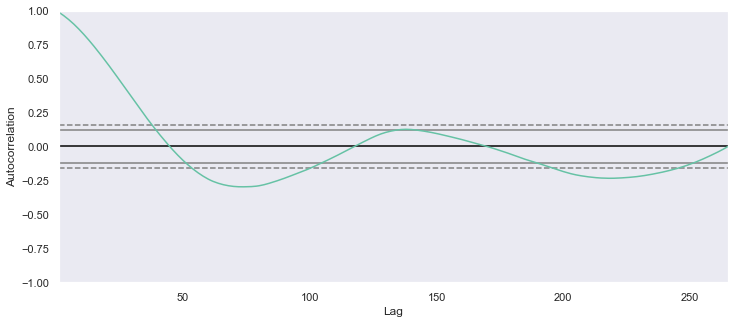



ARIMA
ARIMA(0, 0, 0) MSE=3304762500.868
ARIMA(0, 0, 1) MSE=847128630.427
ARIMA(0, 1, 0) MSE=3746642.901
ARIMA(0, 1, 1) MSE=1184107.902
ARIMA(0, 2, 0) MSE=693001.122
ARIMA(0, 2, 1) MSE=522830.860
ARIMA(0, 2, 2) MSE=528065.494
ARIMA(1, 0, 0) MSE=5403415.016
ARIMA(1, 1, 0) MSE=674512.013
ARIMA(1, 1, 1) MSE=497250.125
ARIMA(1, 2, 0) MSE=613809.482
ARIMA(2, 0, 1) MSE=506401.914
ARIMA(2, 1, 0) MSE=581329.420
ARIMA(2, 2, 0) MSE=521324.954
ARIMA(2, 2, 1) MSE=516454.032
ARIMA(2, 2, 2) MSE=504819.475
ARIMA(4, 0, 1) MSE=517407.763
ARIMA(4, 0, 2) MSE=500938.941
ARIMA(4, 1, 1) MSE=501962.732
ARIMA(4, 1, 2) MSE=497127.900
ARIMA(4, 2, 0) MSE=489292.930
ARIMA(4, 2, 1) MSE=504550.609
ARIMA(6, 0, 1) MSE=501563.137
ARIMA(6, 1, 1) MSE=490832.661
ARIMA(6, 2, 0) MSE=507957.784
ARIMA(6, 2, 1) MSE=516923.041
ARIMA(8, 2, 0) MSE=529940.992
ARIMA(8, 2, 1) MSE=538581.203
ARIMA(10, 2, 0) MSE=520838.000
ARIMA(10, 2, 1) MSE=516011.224
Best ARIMA(4, 2, 0) MSE=489292.930
(4, 2, 0)


In [177]:
master_function(32804)

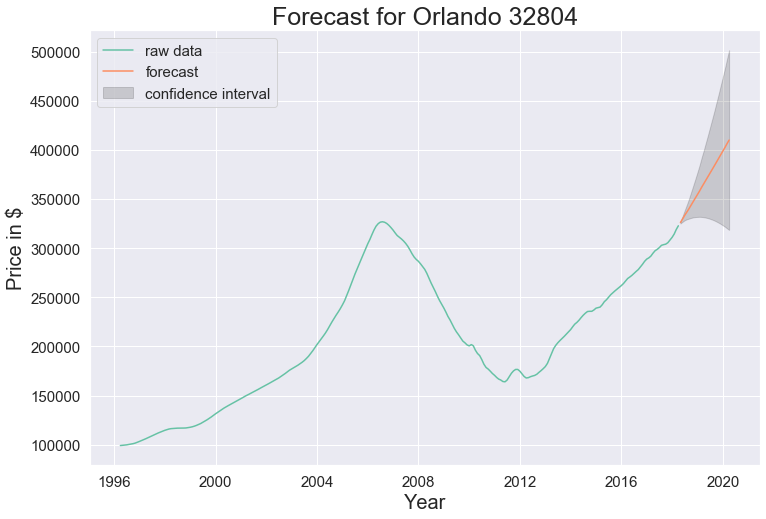



I would expect a  27.0374% return on my investment in 32804
Best case scenario I would expect a  55.3851% return on my investment in 32804
Worst case scenario I would expect a  -1.3103% return on my investment in 32804


In [188]:
final_function(32804,4,2,0)

### Third Zipcode 32801

ZIP code 32801 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a large population density.

The people living in ZIP code 32801 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of middle aged adults is extremely small. There are also an extremely large number of single adults and an extremely small number of families. The percentage of children under 18 living in the 32801 ZIP code is extremely small compared to other areas of the country.

Population	12,050	

Population Density	5,280 people per sq mi

Housing Units	8,492	

Median Home Value	$262,600

Land Area	2.28	sq mi

Water Area	0.15	sq mi

Occupied Housing Units	7,006

Median Household Income	$47,151	


#### Real Estate and Housing

ZIP code 32801 has a slightly higher than average percentage of vacancies. The Census also indicates that there are one or more nursing homes nearby.

The majority of household are rented. Homes in ZIP code 32801 were primarily built in the 2000s. Looking at 32801 real estate data, the median home value of 262,600 is high compared to the rest of the country. It is also extremely high compared to nearby ZIP codes. So you are less likely to find inexpensive homes in 32801. Rentals in 32801 are most commonly 1 bedrooms. The rent for 1 bedrooms is normally 1,000+/month including utilities. Prices for rental property include ZIP code 32801 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32801


,value
time,
1996-04-01,121000.0
1996-05-01,121700.0
1996-06-01,122300.0
1996-07-01,123000.0
1996-08-01,123600.0




Seasonality


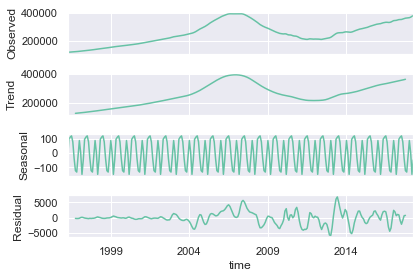



Rolling Meand and Standard Deviation


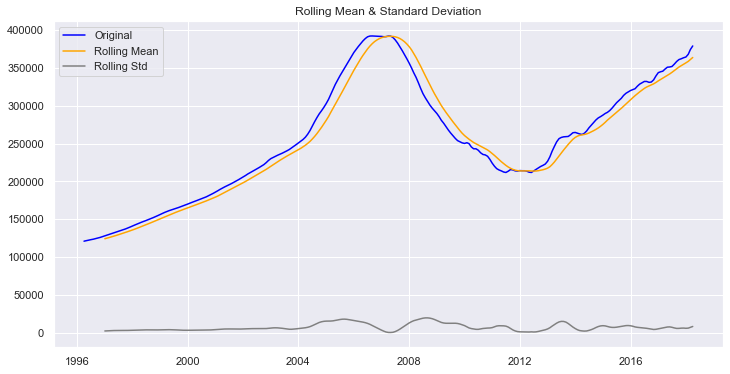



Rolling Meand and Standard Deviation


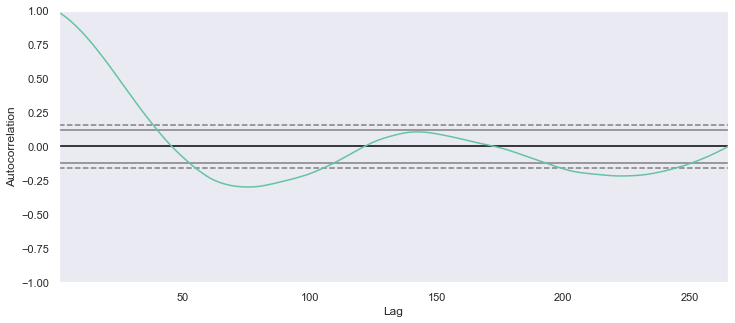



ARIMA
ARIMA(0, 0, 0) MSE=3725098327.991
ARIMA(0, 0, 1) MSE=954356037.937
ARIMA(0, 1, 0) MSE=5879587.231
ARIMA(0, 1, 1) MSE=2346146.151
ARIMA(0, 2, 0) MSE=1766752.473
ARIMA(0, 2, 1) MSE=1352799.774
ARIMA(1, 0, 0) MSE=7758334.185
ARIMA(1, 1, 0) MSE=1710672.460
ARIMA(1, 1, 1) MSE=1268568.389
ARIMA(1, 2, 0) MSE=1615589.961
ARIMA(2, 0, 0) MSE=1730764.085
ARIMA(2, 0, 1) MSE=1283554.626
ARIMA(2, 1, 0) MSE=1511467.628
ARIMA(2, 2, 0) MSE=1193710.937
ARIMA(2, 2, 1) MSE=1228108.276
ARIMA(2, 2, 2) MSE=1156699.580
ARIMA(4, 0, 0) MSE=1184994.116
ARIMA(4, 0, 1) MSE=1210187.472
ARIMA(4, 0, 2) MSE=1119525.105
ARIMA(4, 1, 1) MSE=1243467.056
ARIMA(4, 2, 0) MSE=1252454.646
ARIMA(4, 2, 1) MSE=1285089.259
ARIMA(6, 0, 0) MSE=1232145.519
ARIMA(6, 0, 1) MSE=1266408.565
ARIMA(6, 1, 2) MSE=1112856.084
ARIMA(6, 2, 0) MSE=1300394.625
ARIMA(8, 0, 0) MSE=1283807.325
ARIMA(8, 0, 1) MSE=1223364.078
ARIMA(8, 0, 2) MSE=1112069.369
ARIMA(8, 2, 0) MSE=1260458.530
ARIMA(10, 0, 0) MSE=1247637.202
ARIMA(10, 2, 0) MSE=12614

In [179]:
master_function(32801)

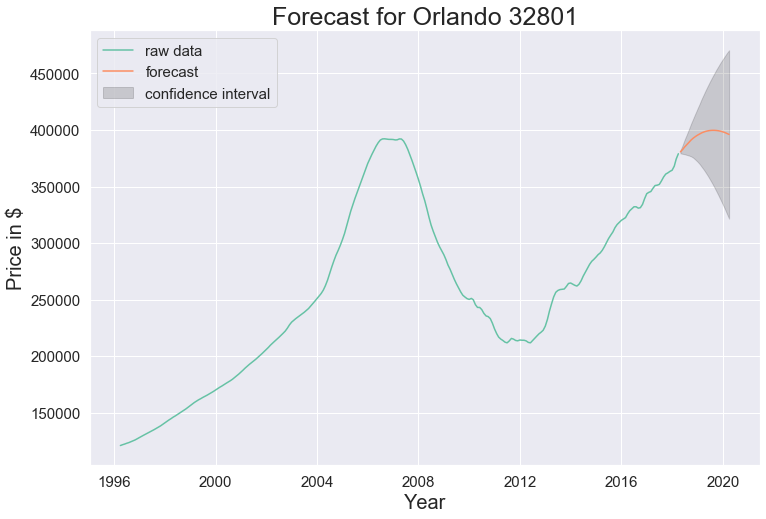



I would expect a  4.4991% return on my investment in 32801
Best case scenario I would expect a  24.1574% return on my investment in 32801
Worst case scenario I would expect a  -15.1592% return on my investment in 32801


In [189]:
final_function(32801,8,0,2)

### Fourth Zipcode 32806

ZIP code 32806 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a slightly higher than average population density.

The people living in ZIP code 32806 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of middle aged adults is large. There are also a large number of single adults and a small number of families. The percentage of children under 18 living in the 32806 ZIP code is small compared to other areas of the country.

Population	24,820	

Population Density	3,726 people per sq mi

Housing Units	12,091	

Median Home Value	$194,300

Land Area	6.66	sq mi

Water Area	0.82	sq mi

Occupied Housing Units	10,993	

Median Household Income	$51,996	

#### Real Estate and Housing

ZIP code 32806 has a slightly less than average percentage of vacancies. The Census also indicates that there are one or more correctional facilities and nursing homes nearby.

The majority of household are owned or have a mortgage. Homes in ZIP code 32806 were primarily built in the 1950s. Looking at 32806 real estate data, the median home value of 194,300 is slightly higher than average compared to the rest of the country. It is also high compared to nearby ZIP codes. So you are less likely to find inexpensive homes in 32806. Rentals in 32806 are most commonly 2 bedrooms. The rent for 2 bedrooms is normally 1,000+/month including utilities. Prices for rental property include ZIP code 32806 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32806


,value
time,
1996-04-01,95300.0
1996-05-01,95400.0
1996-06-01,95500.0
1996-07-01,95600.0
1996-08-01,95800.0




Seasonality


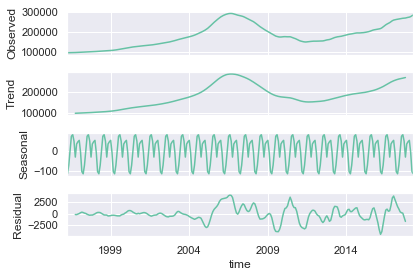



Rolling Meand and Standard Deviation


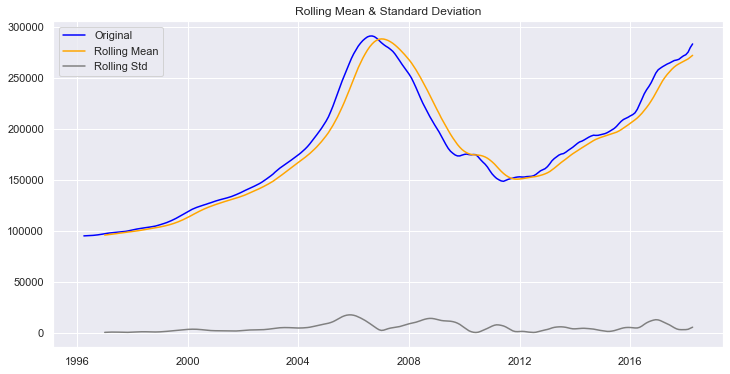



Rolling Meand and Standard Deviation


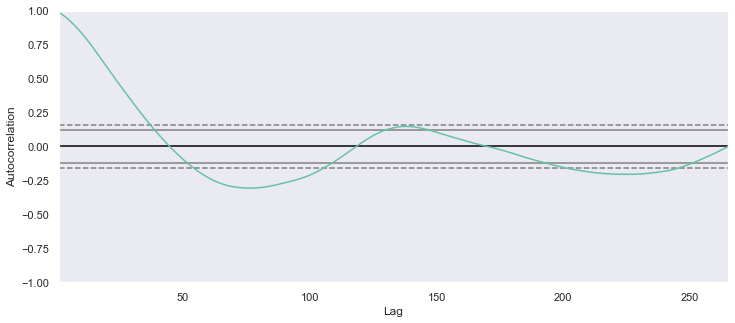



ARIMA
ARIMA(0, 0, 0) MSE=2219419925.467
ARIMA(0, 1, 0) MSE=3255358.184
ARIMA(0, 1, 1) MSE=1109166.824
ARIMA(0, 2, 0) MSE=400341.136
ARIMA(0, 2, 1) MSE=277143.980
ARIMA(1, 1, 0) MSE=395407.828
ARIMA(1, 1, 1) MSE=270428.388
ARIMA(1, 1, 2) MSE=271027.112
ARIMA(1, 2, 0) MSE=361489.240
ARIMA(1, 2, 1) MSE=291118.571
ARIMA(2, 0, 1) MSE=274800.959
ARIMA(2, 0, 2) MSE=274680.527
ARIMA(2, 1, 1) MSE=282656.801
ARIMA(2, 1, 2) MSE=254640.369
ARIMA(2, 2, 0) MSE=292718.634
ARIMA(2, 2, 1) MSE=272387.481
ARIMA(4, 0, 1) MSE=267497.835
ARIMA(4, 1, 1) MSE=257382.777
ARIMA(4, 2, 0) MSE=271004.267
ARIMA(6, 0, 1) MSE=257681.164
ARIMA(6, 1, 1) MSE=257494.359
ARIMA(6, 2, 0) MSE=270235.167
ARIMA(6, 2, 1) MSE=266945.169
ARIMA(8, 0, 1) MSE=262236.112
ARIMA(8, 0, 2) MSE=268654.973
ARIMA(8, 1, 1) MSE=261234.018
ARIMA(8, 2, 0) MSE=277259.942
ARIMA(8, 2, 1) MSE=276730.024
ARIMA(10, 2, 0) MSE=281035.569
ARIMA(10, 2, 1) MSE=285754.274
Best ARIMA(2, 1, 2) MSE=254640.369
(2, 1, 2)


In [190]:
master_function(32806)

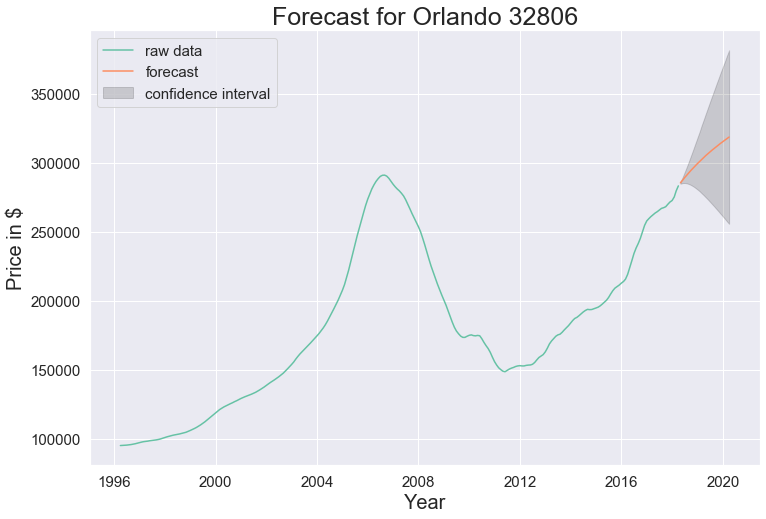



I would expect a  12.4909% return on my investment in 32806
Best case scenario I would expect a  34.6961% return on my investment in 32806
Worst case scenario I would expect a  -9.7143% return on my investment in 32806


In [191]:
final_function(32806,2,1,2)

### Fifth Zipcode 32814

ZIP code 32814 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a large population density.

The people living in ZIP code 32814 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of seniors is small. There are also an extremely large number of single adults and a small number of single parents. The percentage of children under 18 living in the 32814 ZIP code is slightly less than average compared to other areas of the country.

Population	6,151	

Population Density	4,658 people per sq mi

Housing Units	3,090	

Median Home Value	$400,000

Land Area	1.32	sq mi

Water Area	0.42	sq mi

Occupied Housing Units	2,707	

Median Household Income	$96,766	

#### Real Estate and Housing

ZIP code 32814 has a slightly less than average percentage of vacancies. The Census also indicates that there are one or more nursing homes nearby.

The majority of household are rented. Homes in ZIP code 32814 were primarily built in the 2000s. Looking at 32814 real estate data, the median home value of 400,000 is extremely high compared to the rest of the country. It is also extremely high compared to nearby ZIP codes. So you are less likely to find inexpensive homes in 32814. Rentals in 32814 are most commonly 2 bedrooms. The rent for 2 bedrooms is normally $1,000+/month including utilities. 1 bedrooms are also common and rent for 1,000+/month. Prices for rental property include ZIP code 32814 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

Compared to other ZIPs, 32814 has a very small percentage of people that did not graduate high school. The area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32814


,value
time,
1996-04-01,170200.0
1996-05-01,171300.0
1996-06-01,172300.0
1996-07-01,173300.0
1996-08-01,174200.0




Seasonality


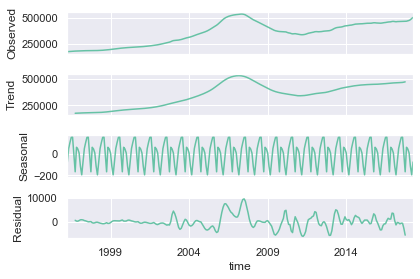



Rolling Meand and Standard Deviation


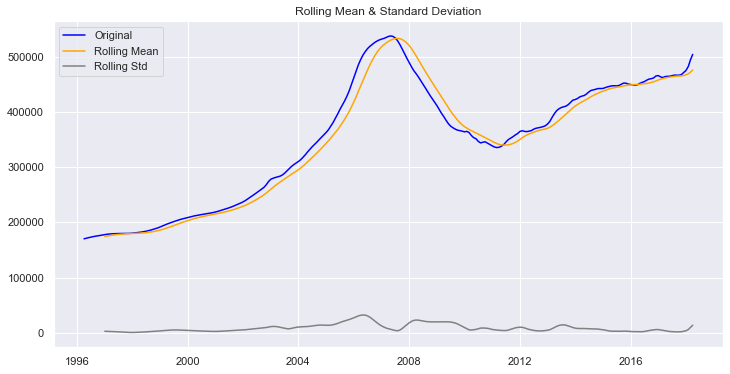



Rolling Meand and Standard Deviation


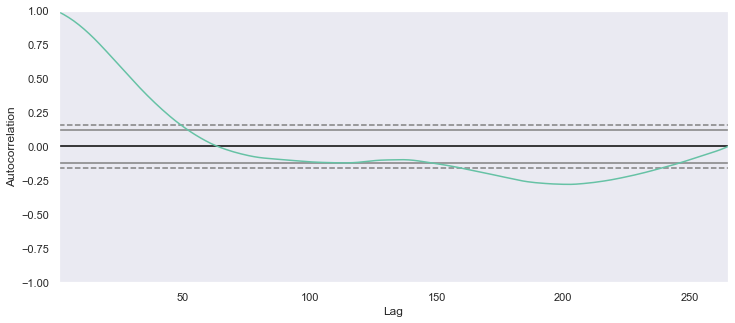



ARIMA
ARIMA(0, 0, 0) MSE=9326890774.604
ARIMA(0, 1, 0) MSE=6221175.808
ARIMA(0, 1, 1) MSE=3064458.441
ARIMA(0, 2, 0) MSE=2129300.174
ARIMA(0, 2, 1) MSE=1961097.710
ARIMA(0, 2, 2) MSE=1920538.160
ARIMA(1, 1, 0) MSE=2098959.599
ARIMA(1, 1, 1) MSE=1869728.203
ARIMA(1, 1, 2) MSE=1872147.020
ARIMA(1, 2, 0) MSE=2150554.877
ARIMA(2, 0, 1) MSE=1900149.980
ARIMA(2, 1, 0) MSE=2072783.452
ARIMA(2, 2, 0) MSE=1832104.257
ARIMA(2, 2, 1) MSE=1786937.637
ARIMA(4, 0, 1) MSE=1790788.902
ARIMA(4, 0, 2) MSE=1581247.518
ARIMA(4, 1, 1) MSE=1776612.490
ARIMA(4, 2, 0) MSE=1848929.884
ARIMA(4, 2, 1) MSE=1814569.079
ARIMA(6, 0, 1) MSE=1825332.663
ARIMA(6, 1, 1) MSE=1652783.783
ARIMA(6, 2, 0) MSE=1777725.893
ARIMA(8, 2, 0) MSE=1749226.821
Best ARIMA(4, 0, 2) MSE=1581247.518
(4, 0, 2)


In [192]:
master_function(32814)

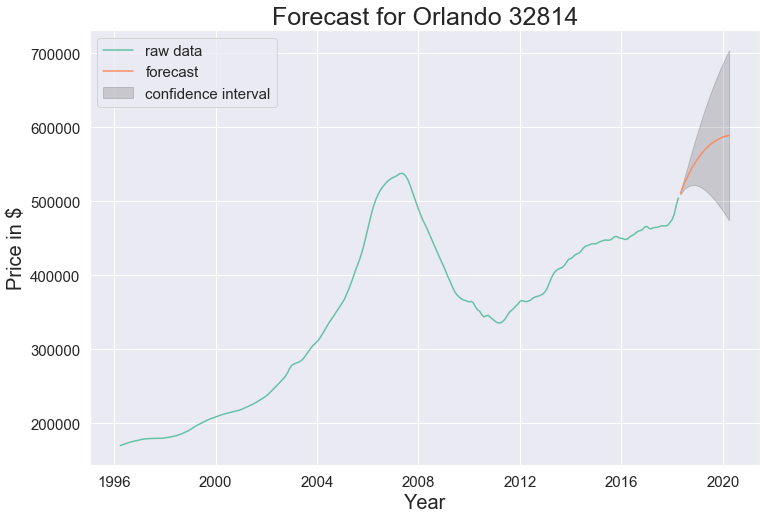



I would expect a  16.7605% return on my investment in 32814
Best case scenario I would expect a  39.5715% return on my investment in 32814
Worst case scenario I would expect a  -6.0506% return on my investment in 32814


In [194]:
final_function(32814,4,0,2)

### Sixth Zipcode 32827

ZIP code 32827 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a slightly less than average population density.

The people living in ZIP code 32827 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of seniors is small. There are also a slightly less than average number of single adults and a slightly higher than average number of families. The percentage of children under 18 living in the 32827 ZIP code is large compared to other areas of the country.

Population	6,362	

Population Density	272	people per sq mi

Housing Units	2,775	

Median Home Value	$235,700	

Land Area	23.41	sq mi

Water Area	1.57	sq mi

Occupied Housing Units	2,393	

Median Household Income	$85,880	

#### Real Estate and Housing

ZIP code 32827 has a slightly less than average percentage of vacancies.

The majority of household are owned or have a mortgage. Homes in ZIP code 32827 were primarily built in the 2000s. Looking at 32827 real estate data, the median home value of 235,700 is high compared to the rest of the country. It is also extremely high compared to nearby ZIP codes. So you are less likely to find inexpensive homes in 32827. Rentals in 32827 are most commonly 3+ bedrooms. The rent for 3+ bedrooms is normally 1,000+/month including utilities. Prices for rental property include ZIP code 32827 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32827


,value
time,
1996-04-01,129300.0
1996-05-01,129700.0
1996-06-01,130100.0
1996-07-01,130300.0
1996-08-01,130400.0




Seasonality


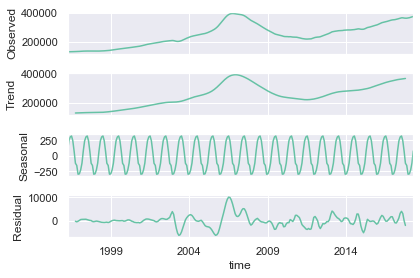



Rolling Meand and Standard Deviation


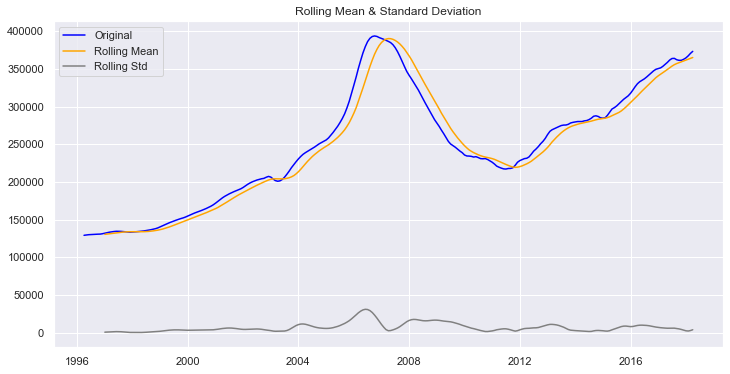



Rolling Meand and Standard Deviation


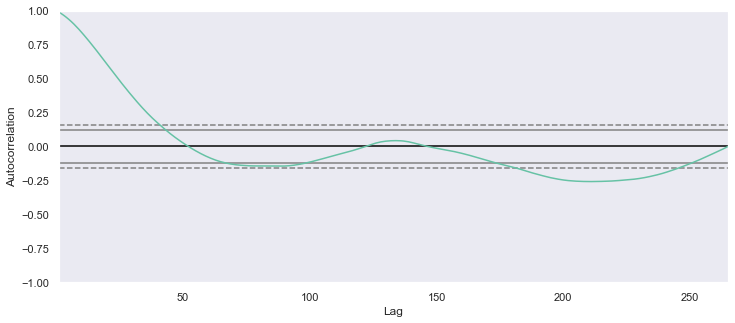



ARIMA
ARIMA(0, 0, 0) MSE=4928215817.818
ARIMA(0, 1, 0) MSE=3722184.496
ARIMA(0, 1, 1) MSE=2050232.590
ARIMA(0, 2, 0) MSE=940875.580
ARIMA(0, 2, 1) MSE=787250.327
ARIMA(0, 2, 2) MSE=800783.717
ARIMA(1, 1, 0) MSE=918131.563
ARIMA(1, 1, 1) MSE=757122.846
ARIMA(1, 1, 2) MSE=760331.978
ARIMA(1, 2, 0) MSE=879168.424
ARIMA(1, 2, 1) MSE=822738.140
ARIMA(1, 2, 2) MSE=666928.325
ARIMA(2, 0, 1) MSE=770948.330
ARIMA(2, 0, 2) MSE=771182.661
ARIMA(2, 1, 0) MSE=835426.512
ARIMA(2, 1, 1) MSE=793884.978
ARIMA(2, 1, 2) MSE=639771.914
ARIMA(2, 2, 0) MSE=819813.075
ARIMA(2, 2, 1) MSE=818000.226
ARIMA(2, 2, 2) MSE=677367.515
ARIMA(4, 0, 1) MSE=801240.477
ARIMA(4, 0, 2) MSE=642495.181
ARIMA(4, 1, 1) MSE=808177.310
ARIMA(4, 1, 2) MSE=681136.371
ARIMA(4, 2, 0) MSE=841801.459
ARIMA(4, 2, 1) MSE=777683.452
ARIMA(6, 0, 1) MSE=757022.082
ARIMA(6, 0, 2) MSE=767009.486
ARIMA(6, 1, 1) MSE=684378.565
ARIMA(6, 1, 2) MSE=654737.031
ARIMA(6, 2, 0) MSE=638729.023
ARIMA(6, 2, 1) MSE=644623.061
ARIMA(6, 2, 2) MSE=650602.

In [195]:
master_function(32827)

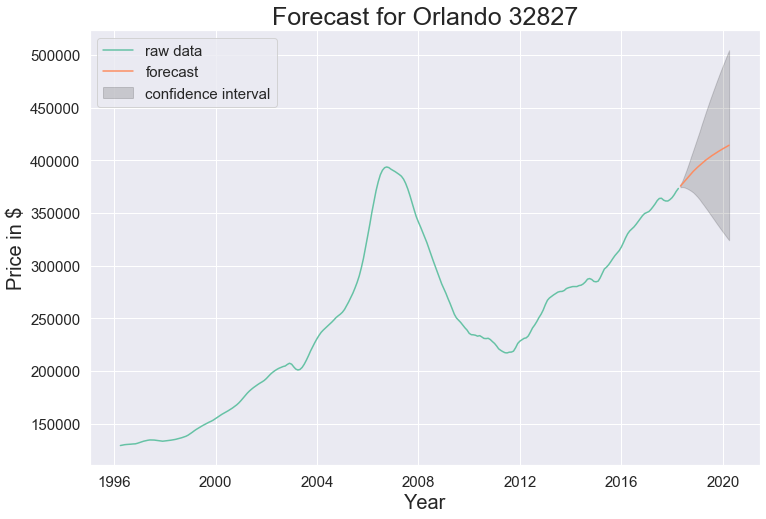



I would expect a  10.99% return on my investment in 32827
Best case scenario I would expect a  35.1562% return on my investment in 32827
Worst case scenario I would expect a  -13.1762% return on my investment in 32827


In [196]:
final_function(32827,8,1,2)

### Seventh Zipcode 32807

ZIP code 32807 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a slightly higher than average population density.

The people living in ZIP code 32807 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of young adults is large. There are also an extremely large number of single parents and a small number of families. The percentage of children under 18 living in the 32807 ZIP code is slightly less than average compared to other areas of the country.

Population	31,465	

Population Density	3,888 people per sq mi

Housing Units	13,151

Median Home Value	$110,600

Land Area	8.09	sq mi

Water Area	0.22	sq mi

Occupied Housing Units	11,764	

Median Household Income	$35,980	

#### Real Estate and Housing

ZIP code 32807 has a slightly less than average percentage of vacancies. The Census also indicates that there are one or more correctional facilities and nursing homes nearby.

The majority of household are owned or have a mortgage. Homes in ZIP code 32807 were primarily built in the 1970s or the 1950s. Looking at 32807 real estate data, the median home value of 110,600 is slightly less than average compared to the rest of the country. It is also low compared to nearby ZIP codes. 32807 could be an area to look for cheap housing compared to surrounding areas. Rentals in 32807 are most commonly 2 bedrooms. The rent for 2 bedrooms is normally 750-999/month including utilities. Prices for rental property include ZIP code 32807 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The percentage of people that did not graduate high school is among the highest in the nation. Despite the lower high school graduation rates, compared to other ZIPs, a much higher percentage of the population has received a college degree.

First Rows From 32807


,value
time,
1996-04-01,68300.0
1996-05-01,68400.0
1996-06-01,68500.0
1996-07-01,68500.0
1996-08-01,68600.0




Seasonality


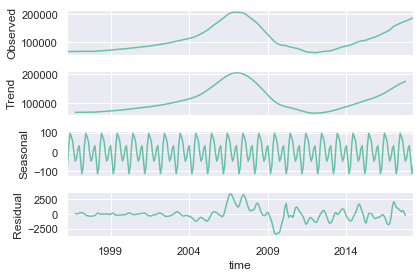



Rolling Meand and Standard Deviation


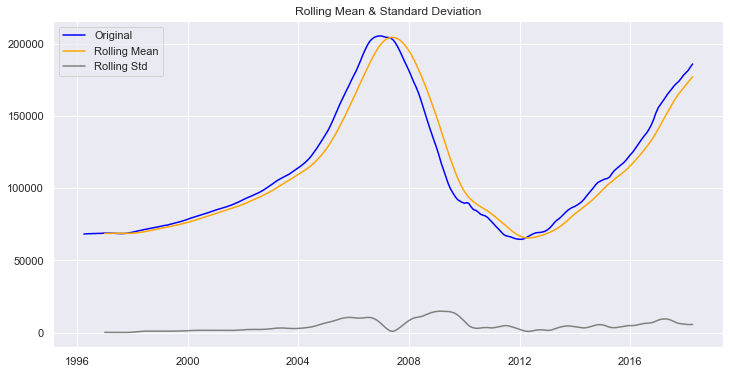



Rolling Meand and Standard Deviation


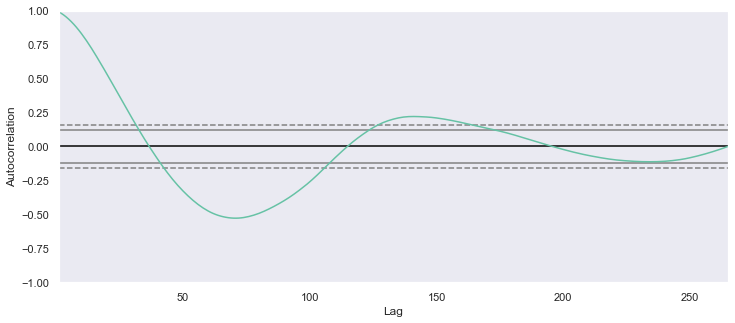



ARIMA
ARIMA(0, 0, 0) MSE=1445153329.170
ARIMA(0, 1, 0) MSE=2416241.364
ARIMA(0, 1, 1) MSE=660645.067
ARIMA(0, 2, 0) MSE=170398.305
ARIMA(0, 2, 1) MSE=120586.492
ARIMA(0, 2, 2) MSE=120246.627
ARIMA(1, 1, 0) MSE=168970.736
ARIMA(1, 1, 1) MSE=118092.000
ARIMA(1, 1, 2) MSE=118550.130
ARIMA(1, 2, 0) MSE=155523.188
ARIMA(1, 2, 1) MSE=120810.586
ARIMA(1, 2, 2) MSE=124768.150
ARIMA(2, 0, 1) MSE=120688.092
ARIMA(2, 0, 2) MSE=120073.615
ARIMA(2, 1, 0) MSE=152521.833
ARIMA(2, 1, 1) MSE=118647.225
ARIMA(2, 1, 2) MSE=121285.839
ARIMA(2, 2, 0) MSE=121611.605
ARIMA(2, 2, 1) MSE=110073.322
ARIMA(2, 2, 2) MSE=103723.011
ARIMA(4, 0, 1) MSE=109972.520
ARIMA(4, 0, 2) MSE=104786.632
ARIMA(4, 1, 1) MSE=112758.359
ARIMA(4, 1, 2) MSE=111849.897
ARIMA(4, 2, 0) MSE=111030.110
ARIMA(4, 2, 1) MSE=111363.951
ARIMA(6, 0, 1) MSE=108354.414
ARIMA(6, 0, 2) MSE=113974.330
ARIMA(6, 1, 1) MSE=110521.354
ARIMA(6, 2, 0) MSE=111428.225
ARIMA(6, 2, 1) MSE=112472.806
ARIMA(6, 2, 2) MSE=114376.865
ARIMA(8, 0, 1) MSE=109831.7

In [197]:
master_function(32807)

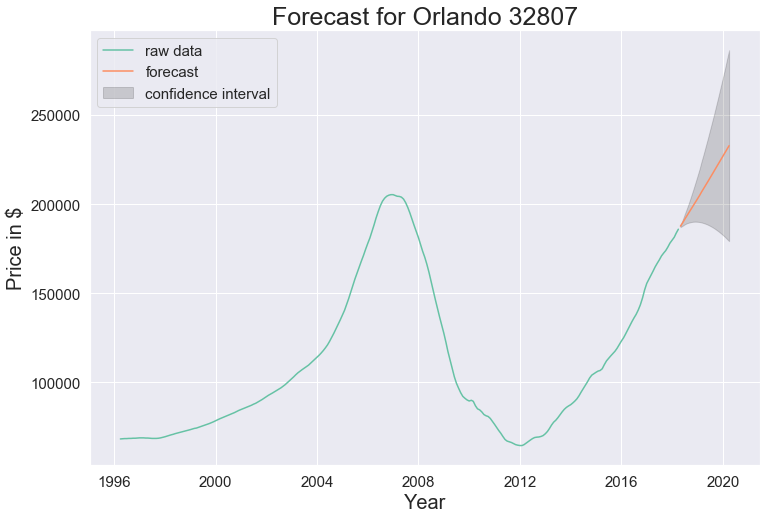



I would expect a  25.209% return on my investment in 32807
Best case scenario I would expect a  54.0205% return on my investment in 32807
Worst case scenario I would expect a  -3.6024% return on my investment in 32807


In [198]:
final_function(32807,2,2,2)

### Eighth Zipcode 32822

ZIP code 32822 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a large population density.

The people living in ZIP code 32822 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of young adults is large. There are also an extremely large number of single parents and an extremely small number of families. The percentage of children under 18 living in the 32822 ZIP code is slightly higher than average compared to other areas of the country.

Population	53,029

Population Density	3,989 people per sq mi

Housing Units	24,862

Median Home Value	$90,700	

Land Area	13.29	sq mi

Water Area	0.68	sq mi

Occupied Housing Units	21,111	

Median Household Income	$32,903	

#### Real Estate and Housing

ZIP code 32822 has a slightly less than average percentage of vacancies. The Census also indicates that there are one or more nursing homes nearby.

The majority of household are rented. Homes in ZIP code 32822 were primarily built in the 1980s or the 1990s. Looking at 32822 real estate data, the median home value of  90,700 is slightly less than average compared to the rest of the country. It is also extremely low compared to nearby ZIP codes. 32822 could be an area to look for cheap housing compared to surrounding areas. Rentals in 32822 are most commonly 2 bedrooms. The rent for 2 bedrooms is normally 750-999/month including utilities. Prices for rental property include ZIP code 32822 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The percentage of people that did not graduate high school is among the highest in the nation. Despite the lower high school graduation rates, the area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32822


,value
time,
1996-04-01,75300.0
1996-05-01,75400.0
1996-06-01,75500.0
1996-07-01,75500.0
1996-08-01,75600.0




Seasonality


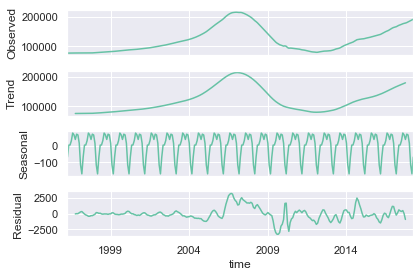



Rolling Meand and Standard Deviation


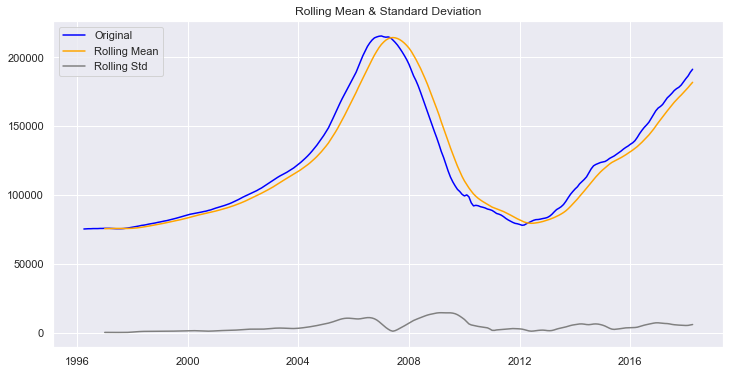



Rolling Meand and Standard Deviation


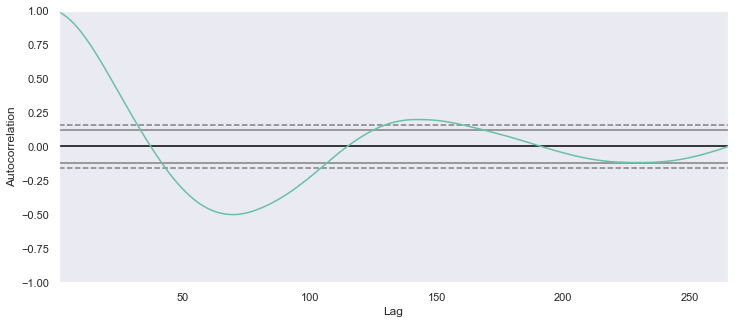



ARIMA
ARIMA(0, 0, 0) MSE=1233387601.049
ARIMA(0, 1, 0) MSE=1947670.919
ARIMA(0, 1, 1) MSE=634283.674
ARIMA(0, 2, 0) MSE=183297.262
ARIMA(0, 2, 1) MSE=170914.107
ARIMA(0, 2, 2) MSE=161861.306
ARIMA(1, 1, 0) MSE=180714.513
ARIMA(1, 1, 1) MSE=164847.977
ARIMA(1, 2, 0) MSE=174999.227
ARIMA(1, 2, 1) MSE=169821.356
ARIMA(2, 0, 1) MSE=167699.520
ARIMA(2, 1, 0) MSE=170414.053
ARIMA(2, 1, 1) MSE=165222.616
ARIMA(2, 2, 0) MSE=141107.577
ARIMA(2, 2, 1) MSE=152482.262
ARIMA(2, 2, 2) MSE=144995.585
ARIMA(4, 0, 1) MSE=154425.300
ARIMA(4, 0, 2) MSE=145887.035
ARIMA(4, 1, 0) MSE=147022.488
ARIMA(4, 1, 1) MSE=150763.090
ARIMA(4, 2, 0) MSE=144737.782
ARIMA(4, 2, 1) MSE=150578.349
ARIMA(6, 0, 1) MSE=150450.824
ARIMA(6, 1, 1) MSE=157445.520
ARIMA(6, 2, 0) MSE=158778.444
ARIMA(6, 2, 1) MSE=157044.658
ARIMA(6, 2, 2) MSE=159518.774
ARIMA(8, 0, 1) MSE=156986.070
ARIMA(8, 0, 2) MSE=150638.520
ARIMA(8, 1, 1) MSE=160264.194
ARIMA(8, 2, 0) MSE=159788.971
ARIMA(8, 2, 1) MSE=166556.674
ARIMA(10, 1, 1) MSE=161500.

In [199]:
master_function(32822)

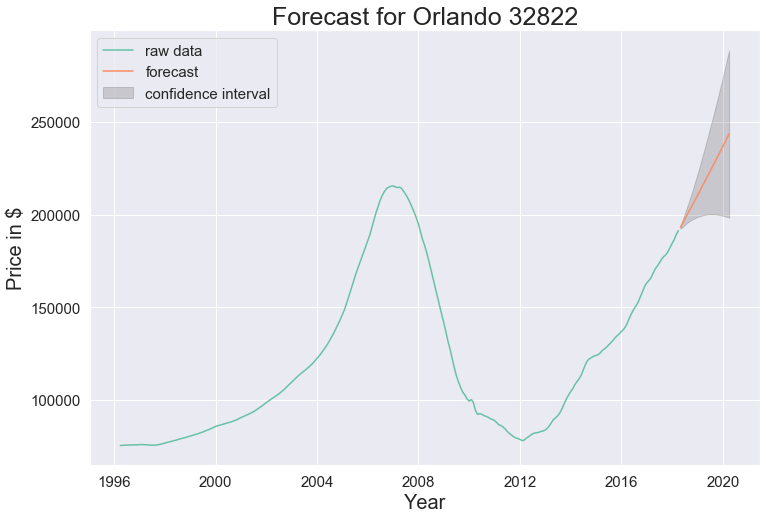



I would expect a  27.2944% return on my investment in 32822
Best case scenario I would expect a  50.9366% return on my investment in 32822
Worst case scenario I would expect a  3.6522% return on my investment in 32822


In [200]:
final_function(32822,2,2,0)

### Nineth Zipcode 32812

ZIP code 32812 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a slightly higher than average population density.

The people living in ZIP code 32812 are primarily white. The number of people in their late 20s to early 40s is extremely large while the number of middle aged adults is large. There are also a small number of families and a large number of single parents. The percentage of children under 18 living in the 32812 ZIP code is slightly less than average compared to other areas of the country.

Population	32,844	

Population Density	3,822 people per sq mi

Housing Units	14,972	

Median Home Value	$174,800

Land Area	8.59	sq mi

Water Area	1.49	sq mi

Occupied Housing Units	13,440	

Median Household Income	$45,934	

#### Real Estate and Housing

ZIP code 32812 has a slightly less than average percentage of vacancies. The Census also indicates that there are one or more nursing homes nearby.

The majority of household are owned or have a mortgage. Homes in ZIP code 32812 were primarily built in the 1980s or the 1970s. Looking at 32812 real estate data, the median home value of 174,800 is slightly higher than average compared to the rest of the country. It is also slightly higher than average compared to nearby ZIP codes. So you are less likely to find inexpensive homes in 32812. Rentals in 32812 are most commonly 2 bedrooms. The rent for 2 bedrooms is normally 750-999/month including utilities. Prices for rental property include ZIP code 32812 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32812


,value
time,
1996-04-01,107900.0
1996-05-01,107900.0
1996-06-01,108000.0
1996-07-01,108000.0
1996-08-01,108100.0




Seasonality


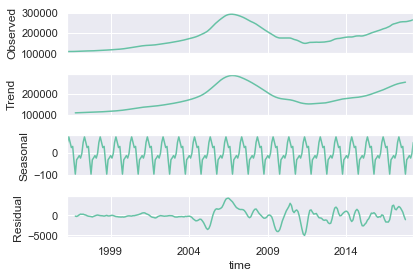



Rolling Meand and Standard Deviation


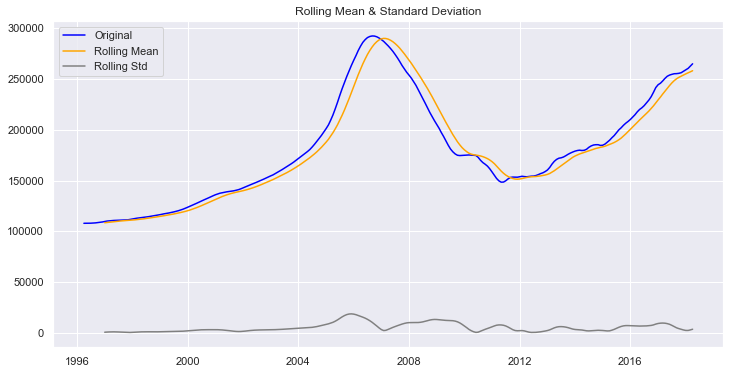



Rolling Meand and Standard Deviation


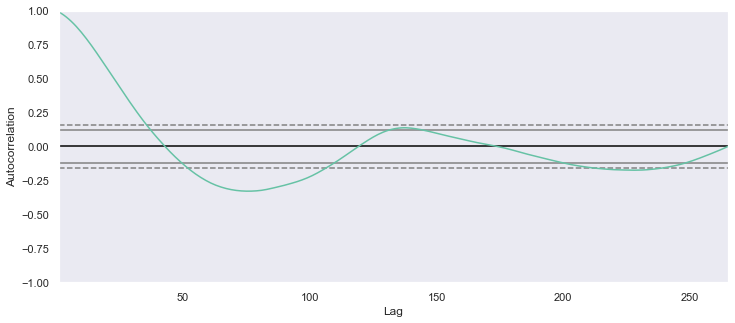



ARIMA
ARIMA(0, 0, 0) MSE=1577670797.549
ARIMA(0, 1, 0) MSE=2616986.470
ARIMA(0, 1, 1) MSE=885964.879
ARIMA(0, 2, 0) MSE=371964.267
ARIMA(0, 2, 1) MSE=290391.702
ARIMA(1, 1, 0) MSE=366168.117
ARIMA(1, 1, 1) MSE=283934.598
ARIMA(1, 1, 2) MSE=283779.111
ARIMA(1, 2, 0) MSE=322207.253
ARIMA(1, 2, 1) MSE=298492.367
ARIMA(1, 2, 2) MSE=283127.424
ARIMA(2, 0, 1) MSE=285829.156
ARIMA(2, 0, 2) MSE=284759.945
ARIMA(2, 1, 1) MSE=290946.987
ARIMA(2, 1, 2) MSE=279395.831
ARIMA(2, 2, 0) MSE=296935.591
ARIMA(2, 2, 1) MSE=298322.335
ARIMA(2, 2, 2) MSE=286113.108
ARIMA(4, 0, 1) MSE=291852.075
ARIMA(4, 1, 1) MSE=302852.708
ARIMA(4, 2, 0) MSE=306475.605
ARIMA(4, 2, 1) MSE=302453.361
ARIMA(6, 0, 1) MSE=293205.790
ARIMA(6, 0, 2) MSE=300141.664
ARIMA(6, 1, 1) MSE=297537.185
ARIMA(6, 2, 0) MSE=311179.241
ARIMA(6, 2, 1) MSE=310837.810
ARIMA(8, 0, 2) MSE=316829.020
ARIMA(8, 2, 0) MSE=315985.520
ARIMA(8, 2, 1) MSE=317055.832
ARIMA(10, 2, 0) MSE=325505.906
ARIMA(10, 2, 1) MSE=329098.982
Best ARIMA(2, 1, 2) MSE=2

In [201]:
master_function(32812)

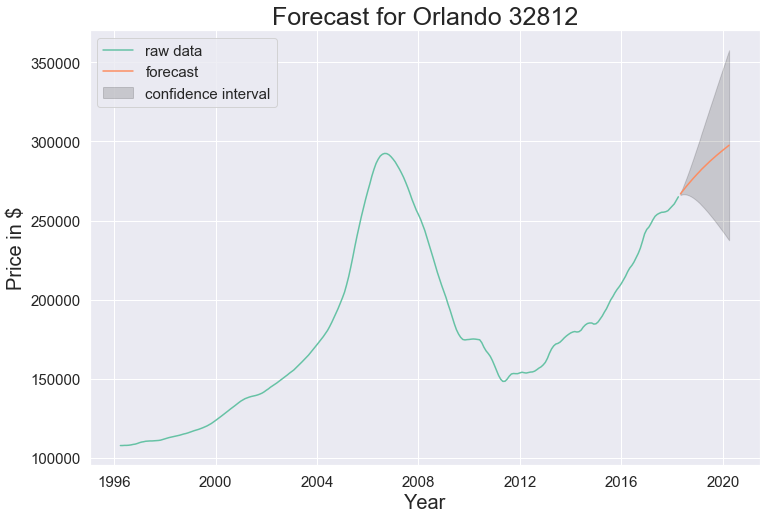



I would expect a  12.2913% return on my investment in 32812
Best case scenario I would expect a  34.9486% return on my investment in 32812
Worst case scenario I would expect a  -10.3661% return on my investment in 32812


In [202]:
final_function(32812,2,1,2)

### Tenth Zipcode 32817

ZIP code 32817 is located in central Florida and covers a slightly less than average land area compared to other ZIP codes in the United States. It also has a slightly higher than average population density.

The people living in ZIP code 32817 are primarily white. The number of young adults is extremely large while the number of seniors is small. There are also a large number of single adults and a small number of families. The percentage of children under 18 living in the 32817 ZIP code is small compared to other areas of the country.

Population	35,105	

Population Density	3,128 people per sq mi

Housing Units	13,404	

Median Home Value	$160,600

Land Area	11.22	sq mi

Water Area	0.80	sq mi

Occupied Housing Units	12,377	

Median Household Income	$44,823	

#### Real Estate and Housing

ZIP code 32817 has a small percentage of vacancies. The Census also indicates that there are one or more nursing homes and universities nearby.

The majority of household are owned or have a mortgage. Homes in ZIP code 32817 were primarily built in the 1980s or the 1990s. Looking at 32817 real estate data, the median home value of 160,600 is slightly higher than average compared to the rest of the country. It is also slightly less than average compared to nearby ZIP codes. 32817 could be an area to look for cheap housing compared to surrounding areas. Rentals in 32817 are most commonly 3+ bedrooms. The rent for 3+ bedrooms is normally 1,000+/month including utilities. Prices for rental property include ZIP code 32817 apartments, townhouses, and homes that are primary residences.

#### Schools and Education

The population has a much higher percentage of people with low education levels (less than high school) than normal. Despite the lower high school graduation rates, the area has some of the highest percentages of people who attended college of any ZIP.

First Rows From 32817


,value
time,
1996-04-01,95900.0
1996-05-01,95800.0
1996-06-01,95700.0
1996-07-01,95500.0
1996-08-01,95400.0




Seasonality


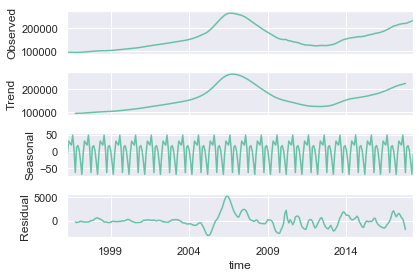



Rolling Meand and Standard Deviation


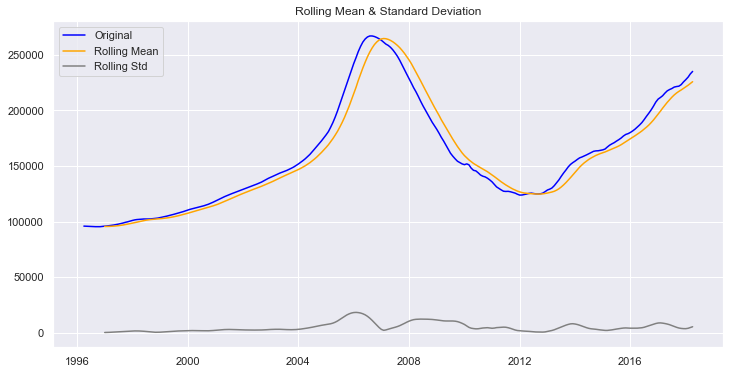



Rolling Meand and Standard Deviation


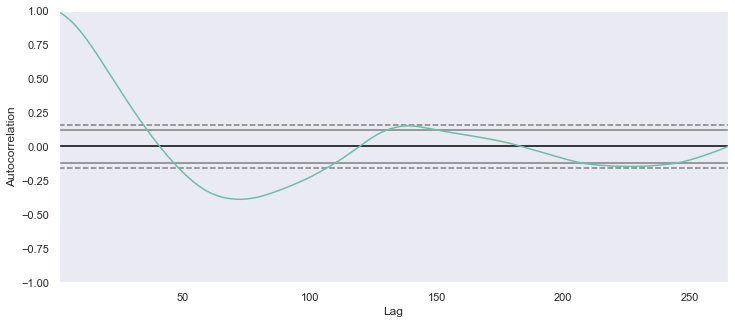



ARIMA
ARIMA(0, 0, 0) MSE=1252909846.373
ARIMA(0, 1, 0) MSE=2142134.739
ARIMA(0, 1, 1) MSE=629368.444
ARIMA(0, 2, 0) MSE=227895.699
ARIMA(0, 2, 1) MSE=172366.395
ARIMA(0, 2, 2) MSE=167596.196
ARIMA(1, 1, 0) MSE=224679.070
ARIMA(1, 1, 1) MSE=167043.402
ARIMA(1, 1, 2) MSE=164456.363
ARIMA(1, 2, 0) MSE=214814.723
ARIMA(1, 2, 1) MSE=170757.795
ARIMA(1, 2, 2) MSE=166379.362
ARIMA(2, 0, 1) MSE=169764.499
ARIMA(2, 0, 2) MSE=167028.153
ARIMA(2, 1, 0) MSE=209386.242
ARIMA(2, 1, 1) MSE=166490.894
ARIMA(2, 1, 2) MSE=163356.061
ARIMA(2, 2, 0) MSE=175497.943
ARIMA(2, 2, 1) MSE=151850.635
ARIMA(2, 2, 2) MSE=138640.179
ARIMA(4, 0, 1) MSE=151978.767
ARIMA(4, 0, 2) MSE=139216.409
ARIMA(4, 1, 1) MSE=152428.255
ARIMA(4, 1, 2) MSE=148027.216
ARIMA(4, 2, 0) MSE=153988.835
ARIMA(6, 0, 1) MSE=158207.760
ARIMA(6, 1, 1) MSE=155059.230
ARIMA(6, 2, 0) MSE=155014.146
ARIMA(6, 2, 1) MSE=153514.768
ARIMA(8, 0, 1) MSE=151101.744
ARIMA(8, 0, 2) MSE=153667.567
ARIMA(8, 1, 1) MSE=158862.292
ARIMA(8, 2, 0) MSE=159720.6

In [203]:
master_function(32817)

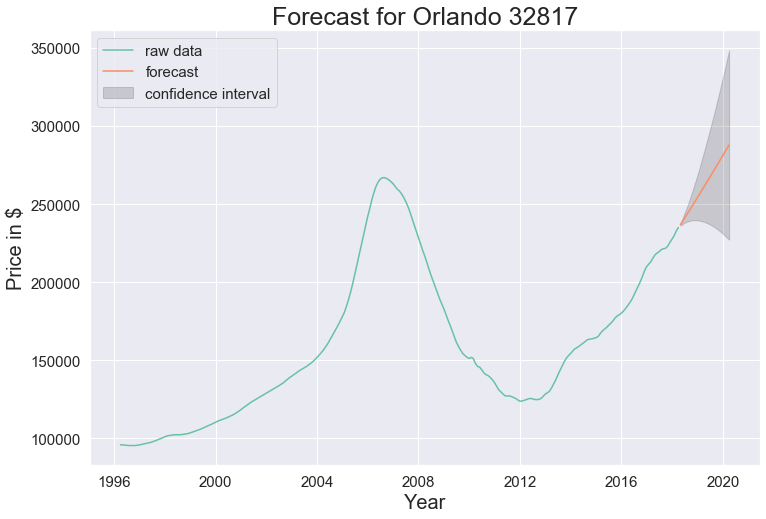



I would expect a  22.4781% return on my investment in 32817
Best case scenario I would expect a  48.317% return on my investment in 32817
Worst case scenario I would expect a  -3.3608% return on my investment in 32817


In [204]:
final_function(32817,2,2,2)

# Results

Let's create a lists and a dataframe including the best 5 zipcodes

In [777]:
Zipcodes = [ '32822','32804', '32807', '32817', '32814']
Return = [27.29, 27.03, 25.02,  22.47, 16.76]
Best = [50.93, 53.38, 54.02, 48.31, 39.57]
Worst = [3.65, -1.31, -3.60, -3.36, -6.05]

Let's plot the three different scenarios.

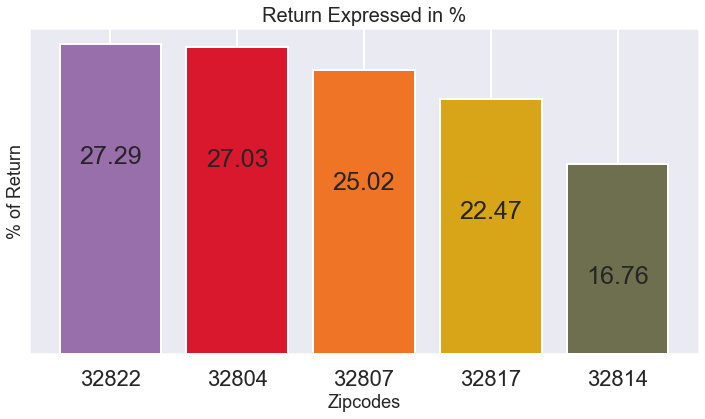

In [778]:
fig = plt.figure(figsize = (12, 6))
plt.bar(Zipcodes, Return, color=['#996FAB', '#D9182D', '#F07426', '#D9A518', '#6D6F4F'])
plt.title('Return Expressed in %', fontsize=20)
plt.ylabel('% of Return', fontsize=18)
plt.xlabel('Zipcodes', fontsize=18)
plt.yticks([])
for i,g in enumerate(Return):
    plt.text (i, g-10, f'{g}', ha='center', fontsize=25,verticalalignment='center',horizontalalignment='center')

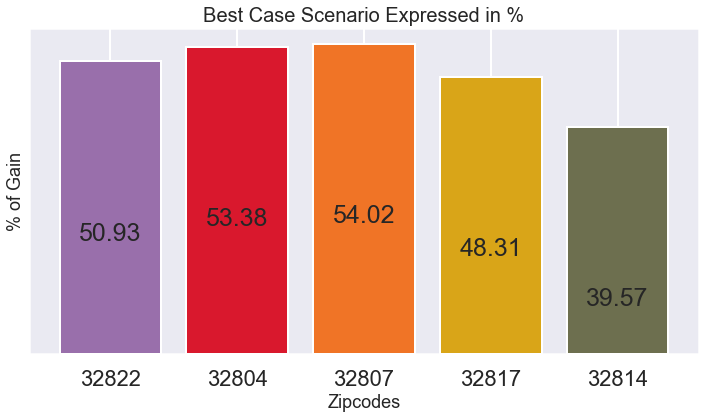

In [779]:
fig = plt.figure(figsize = (12, 6))
plt.bar(Zipcodes, Best, color=['#996FAB', '#D9182D', '#F07426', '#D9A518', '#6D6F4F'])
plt.title('Best Case Scenario Expressed in %', fontsize=20)
plt.ylabel('% of Gain', fontsize=18)
plt.xlabel('Zipcodes', fontsize=18)
plt.yticks([])
for i,g in enumerate(Best):
    plt.text (i, g-30, f'{g}', ha='center', fontsize=25,verticalalignment='center',horizontalalignment='center')

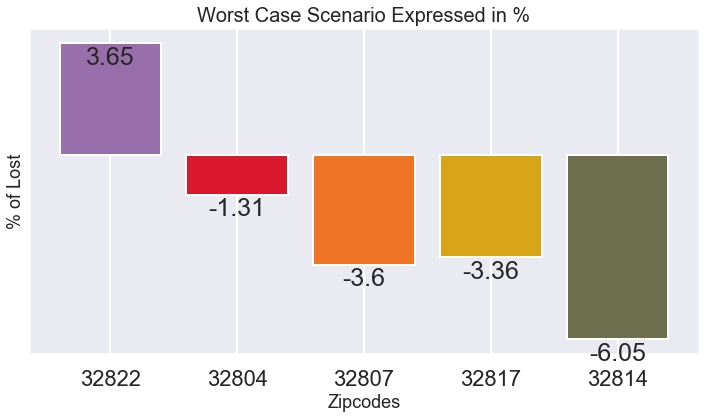

In [780]:
fig = plt.figure(figsize = (12, 6))
plt.bar(Zipcodes, Worst, color=['#996FAB', '#D9182D', '#F07426', '#D9A518', '#6D6F4F'])
plt.title('Worst Case Scenario Expressed in %', fontsize=20)
plt.ylabel('% of Lost', fontsize=18)
plt.xlabel('Zipcodes', fontsize=18)
plt.yticks([])
for i,g in enumerate(Worst):
    plt.text (i, g-.5, f'{g}', ha='center', fontsize=25,verticalalignment='center',horizontalalignment='center')

In [757]:
dfz = pd.DataFrame({'Zipcodes' : ['32822','32804', '32807', '32817', '32814'],
                    'Return' : ['27.29 %', '27.03 %', '25.02 %', '22.47 %', '16.76 %'],
                    'Best' : ['50.93 %', '53.38 %', '54.02 %', '48.31 %', '39.57 %'],
                    'Worst' : [ '3.65 %', '-1.31 %', '-3.60 %','-3.36 %', '-6.05 %']})
dfz.set_index('Zipcodes', inplace = True)
dfz

,Return,Best,Worst
Zipcodes,,,
32822,27.29 %,50.93 %,3.65 %
32804,27.03 %,53.38 %,-1.31 %
32807,25.02 %,54.02 %,-3.60 %
32817,22.47 %,48.31 %,-3.36 %
32814,16.76 %,39.57 %,-6.05 %


We selected the top 10 zipcodes with more ROI in Orlando City to dig deeper and figure out the best 5 to invest.

The best 5 zipcodes to invest are 32804, 32814, 32807, 32822, 32817

We recomend to buy houses between November and January and improve them in order to sell them between May and July. We know from a previous research that those are the perfect months for transactions and the price will increase is the house condition is better.

One interesting fact is that the best zipcodes to invest are located in economic neighborhoods. Their house prices increased more than the medium-high class neighborhoods.